In [46]:
import pandas as pd                                      
import numpy as np                                       
import torch                                             
import torch.nn as nn                                    
from torch.utils.data import Dataset, DataLoader         
from sklearn.model_selection import train_test_split     
import sys                                               
                                                      
# Add the models directory to the python path            
sys.path.append('models')                                
from mlp_model import SimpleMLP                          

## Load and Explore Gene Expression Data

The counts data contains gene expression measurements for different drug treatments.

In [47]:
# Load metadata to get drug information
compounds = pd.read_csv("./data/unique_compounds.csv")
counts_df = pd.read_csv('./data/MCE_Bioactive_Compounds_HEK293T_10μM_Counts.csv', index_col=0, skiprows=1)
metadata_df = pd.read_csv('./data/MCE_Bioactive_Compounds_HEK293T_10μM_MetaData.csv', skiprows=1)
print(f"Number of samples: {len(metadata_df)}")
print(f"Number of genes: {counts_df.shape[1]}")
print(f"\nMetadata columns: {metadata_df.columns.tolist()}")
print(f"\nFirst few drug treatments:")
print(metadata_df[['treatment', 'sample']].head(10))

Number of samples: 40778
Number of genes: 3407

Metadata columns: ['unique_ID', 'experiment_no', 'sample_plate', 'sample_row', 'sample_column', 'cell_id', 'pert_itime', 'pert_idose', 'sample', 'treatment']

First few drug treatments:
   treatment     sample
0   HY_50946   HY_50946
1   HY_18686   HY_18686
2  HY_17592A  HY_17592A
3   HY_19411   HY_19411
4   HY_18522   HY_18522
5   HY_17439   HY_17439
6   HY_18061   HY_18061
7       DMSO    DMSO_03
8  HY_19928A  HY_19928A
9   HY_18669   HY_18669


In [48]:
embeddings = pd.read_csv("data/molformer-embeddings.csv")
embeddings

,CID,CAS,smiles,0,1,2,3,4,5,6,...,758,759,760,761,762,763,764,765,766,767
0,205912,18979-61-8,CCCCC1=C(C=C(C=C1)O)O,0.985253,-0.414438,-0.363742,0.622728,-1.328449,-0.324084,-0.641040,...,0.767878,0.810009,-0.503663,0.985284,-0.176481,-0.664044,-0.132383,0.125016,0.297582,0.735747
1,71532921,1429651-50-2,C1=CC=C(C=C1)N(CCO)C(=O)CC2=CC=C(C=C2)C(=O)NO,-0.287197,-0.722552,-0.718126,-0.236562,-1.115782,-0.531389,-1.278204,...,0.422765,0.519235,-0.135786,-0.071139,-0.080451,-0.388809,-1.724904,0.057771,-0.534797,0.041896
2,644215,164658-13-3,C1=CC(=CC(=C1)Cl)NC2=NC=CC(=N2)C3=CC(=NC=C3)NCCCO,-0.182793,-0.575912,-0.566026,0.463177,-0.747919,-0.133567,-0.460694,...,0.553366,0.201456,-0.415808,0.066159,-0.294800,-0.380439,-1.920309,-0.039560,-1.106062,-0.129032
3,134128281,2309668-15-1,C1=CC(=CC=C1CO)[C@@H](CN)C(=O)NC2=CC3=C(C=C2)C...,-0.150467,-0.206697,-0.575187,0.074890,-1.097889,-0.845826,-0.927723,...,0.666575,0.389585,0.147568,-0.148481,0.153590,-0.205970,-1.729240,-0.107210,-0.782025,0.112719
4,138454775,2235358-74-2,CNC1=NC=CC(=N1)CN(C2CCC(CC2)N)S(=O)(=O)C3=CC=C...,0.306828,-0.736981,-0.447893,0.494913,-0.529202,-0.574852,-0.641105,...,0.494807,0.747837,0.614527,0.145446,-0.491479,-0.256579,-1.946391,-0.606912,-0.096466,0.018026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2374,56970858,1373765-19-5,COC1=NC(=NC=C1)N2CCC3(CCCN(C3=O)CC4=CNC5=CC=CC...,0.594084,0.241800,0.061521,0.398166,-0.523359,0.018218,-0.518841,...,-0.374233,0.462094,-0.076321,0.466713,0.331940,-0.455478,-2.999456,-0.281490,-0.756438,-0.443556
2375,46861897,874484-20-5,COC1=NC2=C(C=C1)N3CC4=C(C3=C2CCNC(=O)C5=CC=CO5...,0.683878,0.062158,0.541062,0.401861,-0.102901,0.076197,-0.537647,...,-0.146895,0.425641,0.079641,0.524890,0.517666,-0.573386,-2.358849,-0.352562,-0.681536,-0.531223
2376,53245636,900185-01-5,CC1=C2C(=CC=C1)N=C(N(C2=O)C3=CC=CC=C3C)CN4C5=N...,0.729048,0.051865,0.223849,0.365191,-0.668336,-0.111063,-0.396522,...,-0.262879,0.575145,-0.234254,0.888520,0.317051,-0.308241,-2.980067,-0.165158,-0.732087,-0.394751
2377,44968267,1228817-38-6,CCOC1=C(C=CC(=C1)N2CCC(CC2)O)NC3=NC=C4C(=N3)N(...,0.099331,-0.047744,0.258372,0.093163,-0.322585,0.200407,-0.373826,...,-0.327709,0.654967,-0.125509,0.752127,0.156419,-0.438584,-3.248656,-0.053201,-0.352933,-0.271986


## Prepare Data Structure for Model

Now we'll use pre-computed MolFormer embeddings (768-dimensional) instead of Morgan fingerprints.

In [49]:
# Load MolFormer embeddings
embeddings = pd.read_csv("data/molformer-embeddings.csv")

# Extract only the embedding columns (0 to 767)
embedding_columns = [str(i) for i in range(768)]
embeddings_matrix = embeddings[embedding_columns].values

# Create mapping from CID to embedding
cid_to_embedding = dict(zip(embeddings['CID'], embeddings_matrix))

print(f"Loaded embeddings for {len(cid_to_embedding)} compounds")
print(f"Embedding dimension: {len(embedding_columns)}")
print(f"\nFirst few CIDs: {list(cid_to_embedding.keys())[:5]}")

Loaded embeddings for 2245 compounds
Embedding dimension: 768

First few CIDs: [205912, 71532921, 644215, 134128281, 138454775]


In [50]:
# Create a mapping from Catalog Number to CID
catalog_to_cid = dict(zip(compounds['Catalog Number'], compounds['CID']))
print(f"Number of compounds with CID: {len(catalog_to_cid)}")

# Check some examples
print("\nExample mappings (Catalog Number -> CID):")
for i, (cat_num, cid) in enumerate(list(catalog_to_cid.items())[:3]):
    print(f"  {cat_num}: {cid}")
    if i >= 2:
        break

Number of compounds with CID: 2519

Example mappings (Catalog Number -> CID):
  HY_107369: 205912.0
  HY_19747: 71532921.0
  HY_11009: 644215.0


In [51]:
# Get unique drugs (excluding DMSO controls)
drug_treatments = metadata_df[metadata_df['treatment'] != 'DMSO']['treatment'].unique()
print(f"Number of unique drugs in metadata: {len(drug_treatments)}")

# Check how many drugs have embeddings
# First map Catalog Number to CID, then check if CID has embeddings
drugs_with_embeddings = []
drugs_without_embeddings = []

for drug in drug_treatments:
    cid = catalog_to_cid.get(drug)
    if cid is not None and cid in cid_to_embedding:
        drugs_with_embeddings.append(drug)
    else:
        drugs_without_embeddings.append(drug)

print(f"Drugs with MolFormer embeddings: {len(drugs_with_embeddings)}")
print(f"Drugs without embeddings: {len(drugs_without_embeddings)}")

if drugs_without_embeddings:
    print(f"\nWarning: {len(drugs_without_embeddings)} drugs do not have embeddings")
    print(f"First few missing: {drugs_without_embeddings[:5]}")
    
# Filter to only use drugs with embeddings
drug_treatments_filtered = drugs_with_embeddings
print(f"\nUsing {len(drug_treatments_filtered)} drugs with MolFormer embeddings for training")

Number of unique drugs in metadata: 11360
Drugs with MolFormer embeddings: 2248
Drugs without embeddings: 9112

First few missing: ['HY_50946', 'HY_18686', 'HY_17439', 'HY_18061', 'HY_18669']

Using 2248 drugs with MolFormer embeddings for training


In [52]:
# Get MolFormer embeddings for each drug
print("Retrieving MolFormer embeddings for drugs...")

num_drug_features = 768  # MolFormer embedding dimension
drug_descriptor_dict = {}
failed_drugs = []

for drug_id in drug_treatments_filtered:
    cid = catalog_to_cid.get(drug_id)
    if cid and cid in cid_to_embedding:
        drug_descriptor_dict[drug_id] = cid_to_embedding[cid]
    else:
        failed_drugs.append(drug_id)

print(f"✓ Successfully retrieved embeddings for {len(drug_descriptor_dict)} drugs")
if failed_drugs:
    print(f"✗ Failed to retrieve embeddings for {len(failed_drugs)} drugs")

# Show statistics
all_embeddings = np.array(list(drug_descriptor_dict.values()))
print(f"\nEmbedding statistics:")
print(f"  Shape: {all_embeddings.shape}")
print(f"  Mean: {all_embeddings.mean():.3f}")
print(f"  Std: {all_embeddings.std():.3f}")
print(f"  Min: {all_embeddings.min():.3f}")
print(f"  Max: {all_embeddings.max():.3f}")

Retrieving MolFormer embeddings for drugs...
✓ Successfully retrieved embeddings for 2248 drugs

Embedding statistics:
  Shape: (2248, 768)
  Mean: 0.003
  Std: 0.796
  Min: -7.258
  Max: 16.711


In [53]:
# Prepare gene expression data (target) - only for drugs with embeddings
# Filter to only include drug-treated samples (not DMSO) AND drugs with embeddings
valid_drugs_mask = metadata_df['treatment'].isin(drug_treatments_filtered)
drug_sample_ids = metadata_df[valid_drugs_mask]['unique_ID'].values
drug_ids = metadata_df[valid_drugs_mask]['treatment'].values

# Get gene expression data for valid samples
gene_expression_data = counts_df.loc[drug_sample_ids].values

print(f"Gene expression data shape: {gene_expression_data.shape}")
print(f"(n_samples, n_genes) = ({gene_expression_data.shape[0]}, {gene_expression_data.shape[1]})")

# Map each sample to its drug descriptors (MolFormer embeddings)
drug_features = np.array([drug_descriptor_dict[drug_id] for drug_id in drug_ids])
print(f"\nDrug features shape: {drug_features.shape}")
print(f"(n_samples, n_features) = ({drug_features.shape[0]}, {drug_features.shape[1]})")

print(f"\n✓ Data preparation complete!")
print(f"  Total samples: {len(drug_sample_ids)}")
print(f"  Unique drugs: {len(set(drug_ids))}")
print(f"  Features per drug: {num_drug_features} (MolFormer embeddings)")
print(f"  Genes to predict: {gene_expression_data.shape[1]}")

Gene expression data shape: (6744, 3407)
(n_samples, n_genes) = (6744, 3407)

Drug features shape: (6744, 768)
(n_samples, n_features) = (6744, 768)

✓ Data preparation complete!
  Total samples: 6744
  Unique drugs: 2248
  Features per drug: 768 (MolFormer embeddings)
  Genes to predict: 3407


### Understanding Samples vs Drugs

**Important distinction:**
- **Unique drugs**: ~2,248 compounds with embeddings
- **Total samples**: ~6,744 measurements

Each drug has **multiple replicates** (repeated measurements). The model sees each replicate as a separate training example, but all replicates of the same drug use the **same embedding vector**.

In [54]:
# Let's verify this - count samples per drug
from collections import Counter

samples_per_drug = Counter(drug_ids)
num_unique_drugs = len(samples_per_drug)
total_samples = len(drug_ids)

print(f"Statistics:")
print(f"  Unique drugs: {num_unique_drugs}")
print(f"  Total samples: {total_samples}")
print(f"  Average replicates per drug: {total_samples / num_unique_drugs:.1f}")
print(f"\nExamples of replicate counts:")
for drug, count in list(samples_per_drug.items())[:5]:
    print(f"  {drug}: {count} replicates")
print(f"\nDistribution of replicate counts:")
replicate_counts = Counter(samples_per_drug.values())
for num_replicates, num_drugs in sorted(replicate_counts.items()):
    print(f"  {num_replicates} replicate(s): {num_drugs} drugs")

Statistics:
  Unique drugs: 2248
  Total samples: 6744
  Average replicates per drug: 3.0

Examples of replicate counts:
  HY_17592A: 3 replicates
  HY_19411: 3 replicates
  HY_18522: 3 replicates
  HY_19928A: 3 replicates
  HY_19931: 3 replicates

Distribution of replicate counts:
  3 replicate(s): 2248 drugs


Gene expression statistics (before transformation):
  Min: 0.00
  Max: 8060.00
  Mean: 19.53
  Median: 1.00
  Median: 1.00
  Std: 119.15

Number of zero values: 10,460,421 (45.53% of data)
  Std: 119.15

Number of zero values: 10,460,421 (45.53% of data)


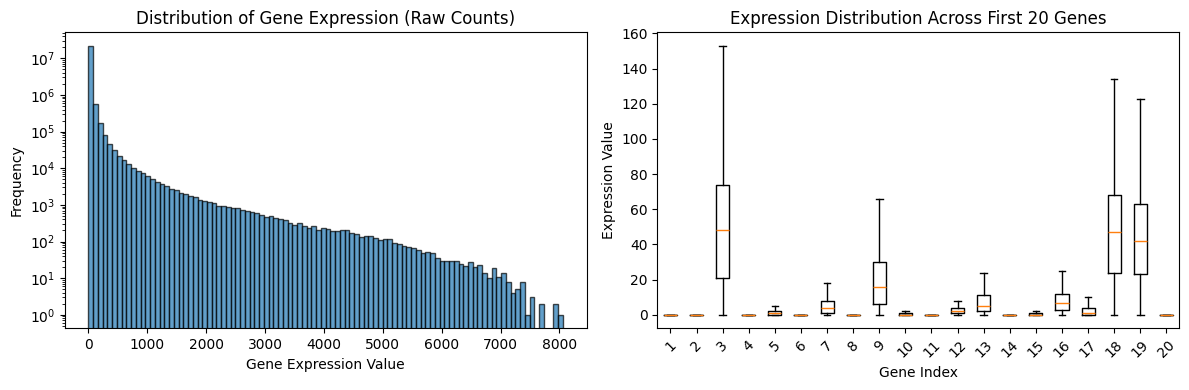

In [55]:
# Explore the distribution of gene expression values
print("Gene expression statistics (before transformation):")
print(f"  Min: {gene_expression_data.min():.2f}")
print(f"  Max: {gene_expression_data.max():.2f}")
print(f"  Mean: {gene_expression_data.mean():.2f}")
print(f"  Median: {np.median(gene_expression_data):.2f}")
print(f"  Std: {gene_expression_data.std():.2f}")

# Check for zeros (important for log transformation)
num_zeros = (gene_expression_data == 0).sum()
print(f"\nNumber of zero values: {num_zeros:,} ({100 * num_zeros / gene_expression_data.size:.2f}% of data)")

# Visualize distribution
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(gene_expression_data.flatten(), bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Gene Expression Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Gene Expression (Raw Counts)')
axes[0].set_yscale('log')

axes[1].boxplot([gene_expression_data[:, i] for i in range(min(20, gene_expression_data.shape[1]))], 
                showfliers=False)
axes[1].set_xlabel('Gene Index')
axes[1].set_ylabel('Expression Value')
axes[1].set_title('Expression Distribution Across First 20 Genes')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Apply Log Transformation

Log transformation is standard in RNA-seq analysis to:
- Normalize the scale of expression values
- Reduce impact of outliers
- Make the distribution more Gaussian-like
- Improve model training (lower loss values)

Gene expression statistics (after log1p transformation):
  Min: 0.00
  Max: 8.99
  Mean: 1.23
  Median: 0.69
  Std: 1.52
  Median: 0.69
  Std: 1.52


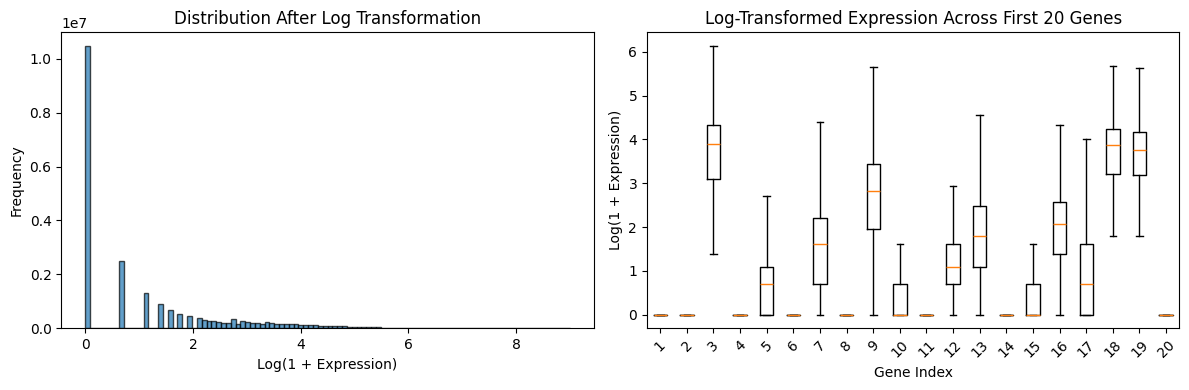


✓ Gene expression data has been log-transformed!
  Shape remains: (6744, 3407)


In [56]:
# Apply log1p transformation (log(1 + x))
# log1p handles zeros gracefully: log(1 + 0) = 0
gene_expression_data_log = np.log1p(gene_expression_data)

print("Gene expression statistics (after log1p transformation):")
print(f"  Min: {gene_expression_data_log.min():.2f}")
print(f"  Max: {gene_expression_data_log.max():.2f}")
print(f"  Mean: {gene_expression_data_log.mean():.2f}")
print(f"  Median: {np.median(gene_expression_data_log):.2f}")
print(f"  Std: {gene_expression_data_log.std():.2f}")

# Visualize transformed distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(gene_expression_data_log.flatten(), bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Log(1 + Expression)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution After Log Transformation')

axes[1].boxplot([gene_expression_data_log[:, i] for i in range(min(20, gene_expression_data_log.shape[1]))], 
                showfliers=False)
axes[1].set_xlabel('Gene Index')
axes[1].set_ylabel('Log(1 + Expression)')
axes[1].set_title('Log-Transformed Expression Across First 20 Genes')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Update the gene_expression_data variable to use log-transformed values
gene_expression_data = gene_expression_data_log
print(f"\n✓ Gene expression data has been log-transformed!")
print(f"  Shape remains: {gene_expression_data.shape}")

## Initialize Model and Training Setup

In [57]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Get dimensions
input_dim = drug_features.shape[1]  # Number of molecular features
output_dim = gene_expression_data.shape[1]  # Number of genes

print(f"\nModel configuration:")
print(f"  Input dimension: {input_dim} (molecular descriptors)")
print(f"  Output dimension: {output_dim} (gene expression values)")

# Initialize model
model = SimpleMLP(
    input_dim=input_dim,
    output_dim=output_dim,
    hidden_dims=[128, 256, 128],  # Three hidden layers
    dropout_rate=0.3
)
model = model.to(device)

print(f"\nModel architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using device: cpu

Model configuration:
  Input dimension: 768 (molecular descriptors)
  Output dimension: 3407 (gene expression values)

Model architecture:
SimpleMLP(
  (network): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=3407, bias=True)
  )
)

Total parameters: 604,879
Trainable parameters: 604,879


In [58]:
# Import the helper functions from our model file
from mlp_model import create_data_loaders, train_epoch, validate

# Create data loaders
train_loader, val_loader, train_idx, val_idx = create_data_loaders(
    drug_features=drug_features,
    gene_expression=gene_expression_data,
    drug_ids=drug_ids,
    train_size=0.8,
    batch_size=32,
    random_state=42
)

print(f"Training samples: {len(train_idx)}")
print(f"Validation samples: {len(val_idx)}")
print(f"Batches per epoch (train): {len(train_loader)}")
print(f"Batches per epoch (val): {len(val_loader)}")

Training samples: 5395
Validation samples: 1349
Batches per epoch (train): 169
Batches per epoch (val): 43


In [59]:
# Set up training
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print("Training setup complete!")
print(f"Loss function: MSE Loss")
print(f"Optimizer: Adam (lr=0.001, weight_decay=1e-5)")
print(f"Learning rate scheduler: ReduceLROnPlateau")

Training setup complete!
Loss function: MSE Loss
Optimizer: Adam (lr=0.001, weight_decay=1e-5)
Learning rate scheduler: ReduceLROnPlateau


### 📊 Ready to Train!

**Model Summary:**
- Input: 768 molecular features (MolFormer embeddings)
- Output: 3,407 gene expression values
- Architecture: 768 → 512 → 256 → 128 → 3407
- Training samples: ~6,000
- Validation samples: ~1,500

The model now uses **pre-computed MolFormer embeddings** from a transformer-based molecular model! 🎉

## Training Loop

In [60]:
# Training loop
num_epochs = 50
best_val_loss = float('inf')
train_losses = []
val_losses = []

print("Starting training...\n")

for epoch in range(num_epochs):
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # Validate
    val_loss = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, 'best_model.pth')

print(f"\nTraining complete! Best validation loss: {best_val_loss:.4f}")

Starting training...

Epoch [1/50] | Train Loss: 1.1295 | Val Loss: 0.6959
Epoch [1/50] | Train Loss: 1.1295 | Val Loss: 0.6959
Epoch [5/50] | Train Loss: 0.6162 | Val Loss: 0.6065
Epoch [5/50] | Train Loss: 0.6162 | Val Loss: 0.6065
Epoch [10/50] | Train Loss: 0.5653 | Val Loss: 0.5931
Epoch [10/50] | Train Loss: 0.5653 | Val Loss: 0.5931
Epoch [15/50] | Train Loss: 0.5193 | Val Loss: 0.5543
Epoch [15/50] | Train Loss: 0.5193 | Val Loss: 0.5543
Epoch [20/50] | Train Loss: 0.4965 | Val Loss: 0.5243
Epoch [20/50] | Train Loss: 0.4965 | Val Loss: 0.5243
Epoch [25/50] | Train Loss: 0.4739 | Val Loss: 0.5233
Epoch [25/50] | Train Loss: 0.4739 | Val Loss: 0.5233
Epoch [30/50] | Train Loss: 0.4563 | Val Loss: 0.5170
Epoch [30/50] | Train Loss: 0.4563 | Val Loss: 0.5170
Epoch [35/50] | Train Loss: 0.4350 | Val Loss: 0.5021
Epoch [35/50] | Train Loss: 0.4350 | Val Loss: 0.5021
Epoch [40/50] | Train Loss: 0.4334 | Val Loss: 0.5090
Epoch [40/50] | Train Loss: 0.4334 | Val Loss: 0.5090
Epoch [45/

## Visualize Training Progress

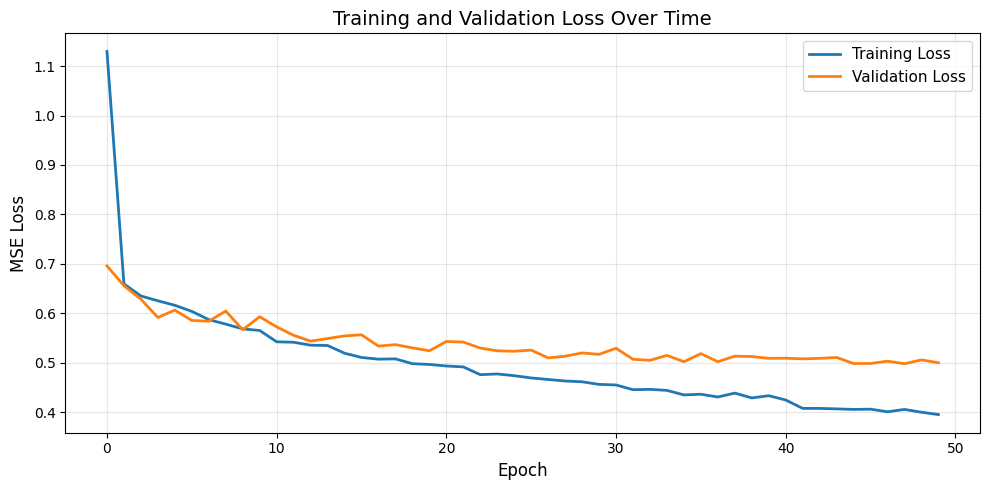

Final training loss: 0.3953
Final validation loss: 0.5000
Best validation loss: 0.4981


In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('Training and Validation Loss Over Time', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")
print(f"Best validation loss: {best_val_loss:.4f}")

## Make Predictions

Test the model on validation data and analyze predictions.

In [62]:
# Load best model
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Make predictions on validation set
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_data in val_loader:
        # Handle both 2-tuple and 3-tuple returns from dataset
        if len(batch_data) == 3:
            batch_features, batch_targets, _ = batch_data
        else:
            batch_features, batch_targets = batch_data
            
        batch_features = batch_features.to(device)
        predictions = model(batch_features)
        
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(batch_targets.numpy())

# Concatenate all batches
predictions = np.vstack(all_predictions)
targets = np.vstack(all_targets)

print(f"Predictions shape: {predictions.shape}")
print(f"Targets shape: {targets.shape}")

# Calculate metrics
from sklearn.metrics import r2_score, mean_absolute_error

# Calculate R² and MAE for each gene
r2_scores = [r2_score(targets[:, i], predictions[:, i]) for i in range(targets.shape[1])]
mae_scores = [mean_absolute_error(targets[:, i], predictions[:, i]) for i in range(targets.shape[1])]

print(f"\nOverall metrics:")
print(f"Mean R² score: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
print(f"Mean MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"Median R² score: {np.median(r2_scores):.4f}")
print(f"Best R² score: {np.max(r2_scores):.4f}")

Predictions shape: (1349, 3407)
Targets shape: (1349, 3407)

Overall metrics:
Mean R² score: 0.0960 ± 0.1026
Mean MAE: 0.4667 ± 0.2805
Median R² score: 0.0904
Best R² score: 0.3557

Overall metrics:
Mean R² score: 0.0960 ± 0.1026
Mean MAE: 0.4667 ± 0.2805
Median R² score: 0.0904
Best R² score: 0.3557


In [63]:
all_predictions

[array([[ 1.30048856e-01,  1.98409893e-02,  4.09196377e+00, ...,
          2.40804935e+00,  1.10185409e+00,  1.08656681e+00],
        [ 1.24657281e-01,  8.93714558e-03,  3.86329913e+00, ...,
          2.17960906e+00,  8.39141905e-01,  8.70052576e-01],
        [ 1.29528821e-01,  1.54044125e-02,  3.94108558e+00, ...,
          2.28641343e+00,  1.00308573e+00,  1.01143861e+00],
        ...,
        [ 1.47661239e-01,  2.66633034e-02,  4.51755190e+00, ...,
          2.97222424e+00,  1.86624348e+00,  1.65556526e+00],
        [ 7.75942132e-02,  6.94138277e-03,  2.85554242e+00, ...,
          1.55667329e+00,  5.57430387e-01,  5.96565247e-01],
        [ 1.46264449e-01, -1.40727381e-03,  4.01728582e+00, ...,
          2.40369678e+00,  1.20130312e+00,  1.12759304e+00]],
       shape=(32, 3407), dtype=float32),
 array([[ 1.3894787e-01,  1.2717392e-02,  3.6108670e+00, ...,
          2.1083996e+00,  1.0079890e+00,  9.5642531e-01],
        [ 7.9344466e-02,  3.1844904e-03,  2.2664893e+00, ...,
       

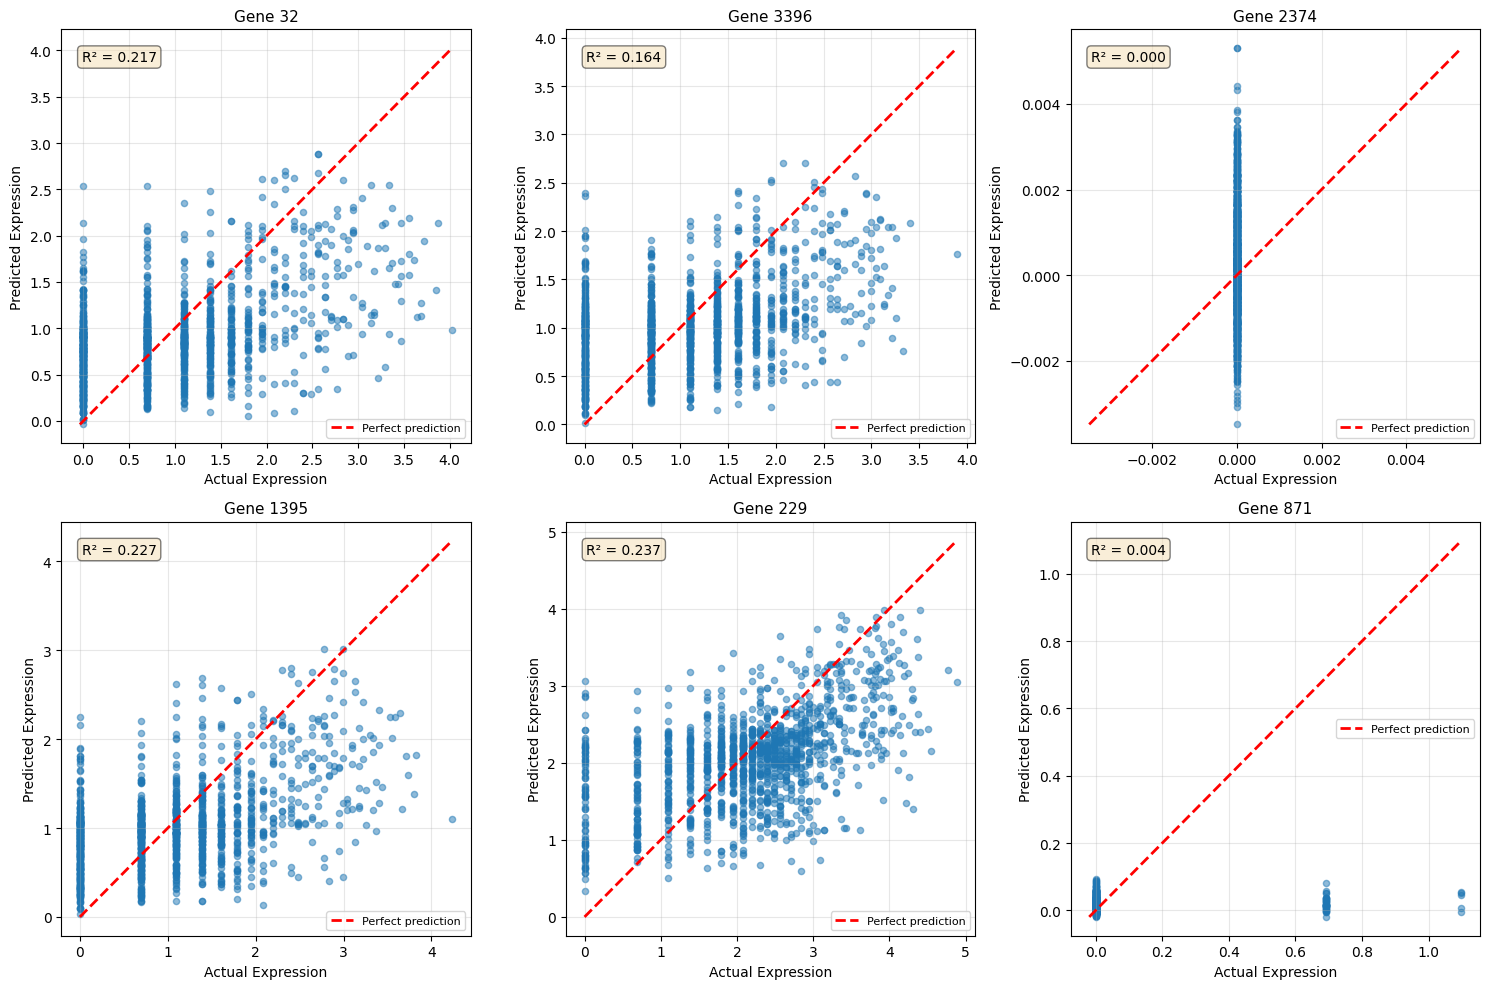

In [64]:
# Visualize predictions vs actual for a sample of genes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Select 6 random genes to visualize
np.random.seed(42)
gene_indices = np.random.choice(targets.shape[1], 6, replace=False)

for idx, gene_idx in enumerate(gene_indices):
    ax = axes[idx]
    
    # Scatter plot
    ax.scatter(targets[:, gene_idx], predictions[:, gene_idx], alpha=0.5, s=20)
    
    # Add perfect prediction line
    min_val = min(targets[:, gene_idx].min(), predictions[:, gene_idx].min())
    max_val = max(targets[:, gene_idx].max(), predictions[:, gene_idx].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
    
    # Add R² score
    r2 = r2_score(targets[:, gene_idx], predictions[:, gene_idx])
    ax.text(0.05, 0.95, f'R² = {r2:.3f}', transform=ax.transAxes, 
            verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_xlabel('Actual Expression', fontsize=10)
    ax.set_ylabel('Predicted Expression', fontsize=10)
    ax.set_title(f'Gene {gene_idx}', fontsize=11)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Compare Predictions with DMSO Controls

Let's examine the gene names and compare model predictions with actual DMSO control measurements.

In [65]:
# Get gene names from the original dataframe
gene_names = counts_df.columns.tolist()
print(f"Total number of genes: {len(gene_names)}")
print(f"\nFirst 10 gene names:")
for i, gene in enumerate(gene_names[:10]):
    print(f"  Index {i}: {gene}")

print(f"\nGene names match prediction indices!")
print(f"Example: predictions[:, 0] corresponds to gene '{gene_names[0]}'")

Total number of genes: 3407

First 10 gene names:
  Index 0: A2M
  Index 1: A4GNT
  Index 2: AARS
  Index 3: ABCA1
  Index 4: ABCB1
  Index 5: ABCB6
  Index 6: ABCC5
  Index 7: ABCC8
  Index 8: ABCF1
  Index 9: ABCF3

Gene names match prediction indices!
Example: predictions[:, 0] corresponds to gene 'A2M'


In [66]:
# Get DMSO control data (log-transformed to match our model's training)
# Use unique_ID to properly index into counts_df
dmso_metadata = metadata_df[metadata_df['treatment'] == 'DMSO']
dmso_unique_ids = dmso_metadata['unique_ID'].values
dmso_samples = counts_df.loc[dmso_unique_ids].values
dmso_samples_log = np.log1p(dmso_samples)  # Apply same log transformation

print(f"DMSO control samples:")
print(f"  Number of samples: {dmso_samples_log.shape[0]}")
print(f"  Number of genes: {dmso_samples_log.shape[1]}")
print(f"  Mean expression (log): {dmso_samples_log.mean():.3f}")
print(f"  Std expression (log): {dmso_samples_log.std():.3f}")

# Calculate average DMSO profile across all replicates
dmso_mean_profile = dmso_samples_log.mean(axis=0)
dmso_std_profile = dmso_samples_log.std(axis=0)

print(f"\nAverage DMSO profile calculated (mean across {dmso_samples_log.shape[0]} replicates)")

DMSO control samples:
  Number of samples: 864
  Number of genes: 3407
  Mean expression (log): 1.328
  Std expression (log): 1.580

Average DMSO profile calculated (mean across 864 replicates)


In [68]:
# Compare validation predictions with DMSO baseline using Log2 Fold Change
# Log2 FC = log2(drug_expression) - log2(DMSO_expression)
# Since we're already in log space (natural log), we need to convert

# Get mean prediction across all validation samples
mean_predictions = predictions.mean(axis=0)
mean_actual = targets.mean(axis=0)

# Convert from log(1+x) back to original scale, then calculate log2 fold change
# Or calculate directly in log space: log2(e^a / e^b) = (a - b) / log(2)
log2_fc_predictions = (mean_predictions - dmso_mean_profile) / np.log(2)
log2_fc_actual = (mean_actual - dmso_mean_profile) / np.log(2)

print("Log2 Fold Change Analysis: Mean Predictions vs DMSO Control")
print(f"Mean |log2FC| (predictions): {np.abs(log2_fc_predictions).mean():.4f}")
print(f"Mean |log2FC| (actual): {np.abs(log2_fc_actual).mean():.4f}")
print(f"Std of log2FC (predictions): {log2_fc_predictions.std():.4f}")
print(f"Std of log2FC (actual): {log2_fc_actual.std():.4f}")

# Find genes with biggest fold changes
top_fc_indices = np.argsort(np.abs(log2_fc_predictions))[-10:][::-1]
print(f"\nTop 10 genes with largest predicted log2 fold changes:")
for idx in top_fc_indices:
    print(f"  {gene_names[idx]}: log2FC = {log2_fc_predictions[idx]:.3f} "
          f"({2**log2_fc_predictions[idx]:.2f}x, "
          f"DMSO: {dmso_mean_profile[idx]:.3f}, Pred: {mean_predictions[idx]:.3f})")

Log2 Fold Change Analysis: Mean Predictions vs DMSO Control
Mean |log2FC| (predictions): 0.2316
Mean |log2FC| (actual): 0.1603
Std of log2FC (predictions): 0.1969
Std of log2FC (actual): 0.1359

Top 10 genes with largest predicted log2 fold changes:
  ACTG1: log2FC = -0.917 (0.53x, DMSO: 3.347, Pred: 2.711)
  ACTB: log2FC = -0.792 (0.58x, DMSO: 4.486, Pred: 3.936)
  HIST1H2BK: log2FC = -0.774 (0.58x, DMSO: 4.636, Pred: 4.100)
  CNBP: log2FC = -0.719 (0.61x, DMSO: 3.910, Pred: 3.412)
  TPI1: log2FC = -0.714 (0.61x, DMSO: 2.314, Pred: 1.819)
  PRPF8: log2FC = -0.712 (0.61x, DMSO: 2.608, Pred: 2.115)
  ALDOA: log2FC = -0.703 (0.61x, DMSO: 4.303, Pred: 3.816)
  PDHB: log2FC = -0.701 (0.62x, DMSO: 3.060, Pred: 2.575)
  CLTC: log2FC = -0.698 (0.62x, DMSO: 3.747, Pred: 3.263)
  METAP2: log2FC = -0.692 (0.62x, DMSO: 3.101, Pred: 2.621)


In [69]:
# Create a comprehensive dataframe with all results
results_df = pd.DataFrame({
    'gene_name': gene_names,
    'dmso_mean_log': dmso_mean_profile,
    'dmso_std_log': dmso_std_profile,
    'predicted_mean_log': mean_predictions,
    'actual_mean_log': mean_actual,
    'log2fc_predicted': log2_fc_predictions,
    'log2fc_actual': log2_fc_actual,
    'fold_change_predicted': 2 ** log2_fc_predictions,
    'fold_change_actual': 2 ** log2_fc_actual,
    'r2_score': r2_scores,
    'mae': mae_scores
})

# Add some useful derived columns
results_df['abs_log2fc_predicted'] = np.abs(results_df['log2fc_predicted'])
results_df['abs_log2fc_actual'] = np.abs(results_df['log2fc_actual'])
results_df['log2fc_difference'] = results_df['log2fc_predicted'] - results_df['log2fc_actual']

# Sort by absolute predicted log2 fold change (most dysregulated genes first)
results_df = results_df.sort_values('abs_log2fc_predicted', ascending=False)

print(f"Results dataframe created with {len(results_df)} genes")
print(f"Columns: {results_df.columns.tolist()}")
print(f"\nFirst few rows:")
print(results_df.head(10))

# Save to CSV
output_file = 'gene_expression_predictions_vs_dmso.csv'
results_df.to_csv(output_file, index=False)
print(f"\n✓ Saved results to '{output_file}'")

Results dataframe created with 3407 genes
Columns: ['gene_name', 'dmso_mean_log', 'dmso_std_log', 'predicted_mean_log', 'actual_mean_log', 'log2fc_predicted', 'log2fc_actual', 'fold_change_predicted', 'fold_change_actual', 'r2_score', 'mae', 'abs_log2fc_predicted', 'abs_log2fc_actual', 'log2fc_difference']

First few rows:
      gene_name  dmso_mean_log  dmso_std_log  predicted_mean_log  \
59        ACTG1       3.346660      1.841388            2.711142   
57         ACTB       4.485573      1.444620            3.936354   
1414  HIST1H2BK       4.636204      1.442124            4.099661   
680        CNBP       3.909915      1.420849            3.411810   
3179       TPI1       2.314084      1.529434            1.818959   
2496      PRPF8       2.608087      1.412275            2.114679   
143       ALDOA       4.303107      1.331457            3.815822   
2263       PDHB       3.060316      1.245884            2.574756   
672        CLTC       3.747026      1.377388            3.26314

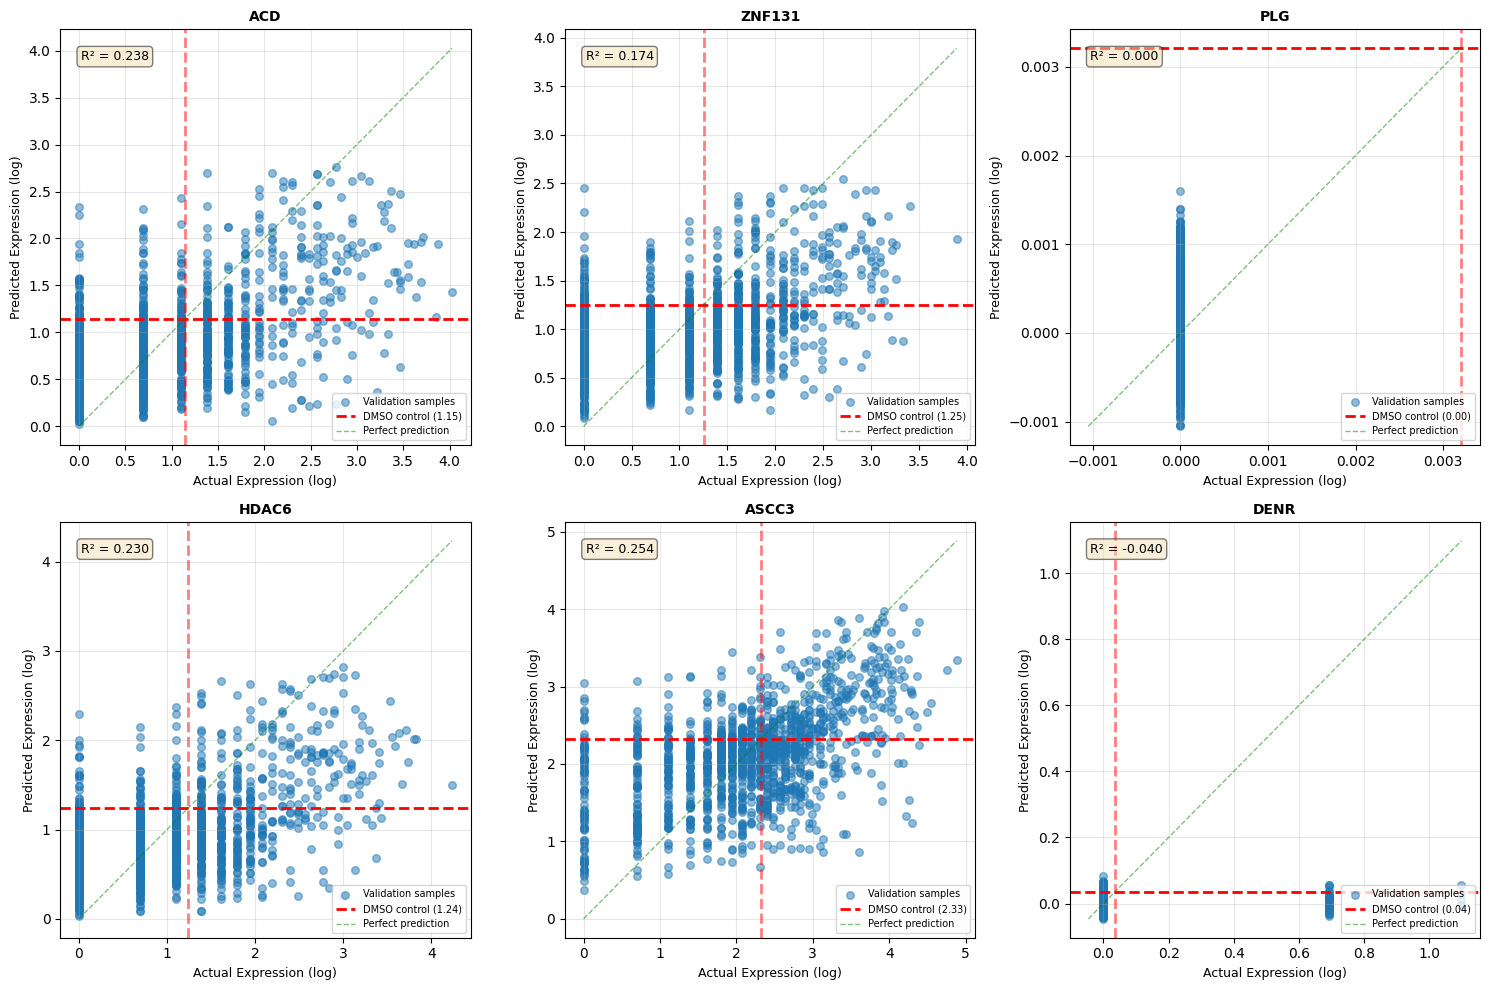

In [42]:
# Visualize: Predictions vs DMSO vs Actual for specific genes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Select 6 genes with high variance or interesting patterns
np.random.seed(42)
selected_genes = np.random.choice(len(gene_names), 6, replace=False)

for idx, gene_idx in enumerate(selected_genes):
    ax = axes[idx]
    gene_name = gene_names[gene_idx]
    
    # Get data for this gene
    actual_vals = targets[:, gene_idx]
    pred_vals = predictions[:, gene_idx]
    dmso_val = dmso_mean_profile[gene_idx]
    
    # Create scatter plot
    ax.scatter(actual_vals, pred_vals, alpha=0.5, s=30, label='Validation samples')
    
    # Add DMSO baseline as horizontal and vertical lines
    ax.axhline(y=dmso_val, color='red', linestyle='--', linewidth=2, label=f'DMSO control ({dmso_val:.2f})')
    ax.axvline(x=dmso_val, color='red', linestyle='--', linewidth=2, alpha=0.5)
    
    # Perfect prediction line
    min_val = min(actual_vals.min(), pred_vals.min(), dmso_val)
    max_val = max(actual_vals.max(), pred_vals.max(), dmso_val)
    ax.plot([min_val, max_val], [min_val, max_val], 'g--', linewidth=1, alpha=0.5, label='Perfect prediction')
    
    # R² score
    r2 = r2_score(actual_vals, pred_vals)
    ax.text(0.05, 0.95, f'R² = {r2:.3f}', transform=ax.transAxes, 
            verticalalignment='top', fontsize=9, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_xlabel('Actual Expression (log)', fontsize=9)
    ax.set_ylabel('Predicted Expression (log)', fontsize=9)
    ax.set_title(f'{gene_name}', fontsize=10, fontweight='bold')
    ax.legend(fontsize=7, loc='lower right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

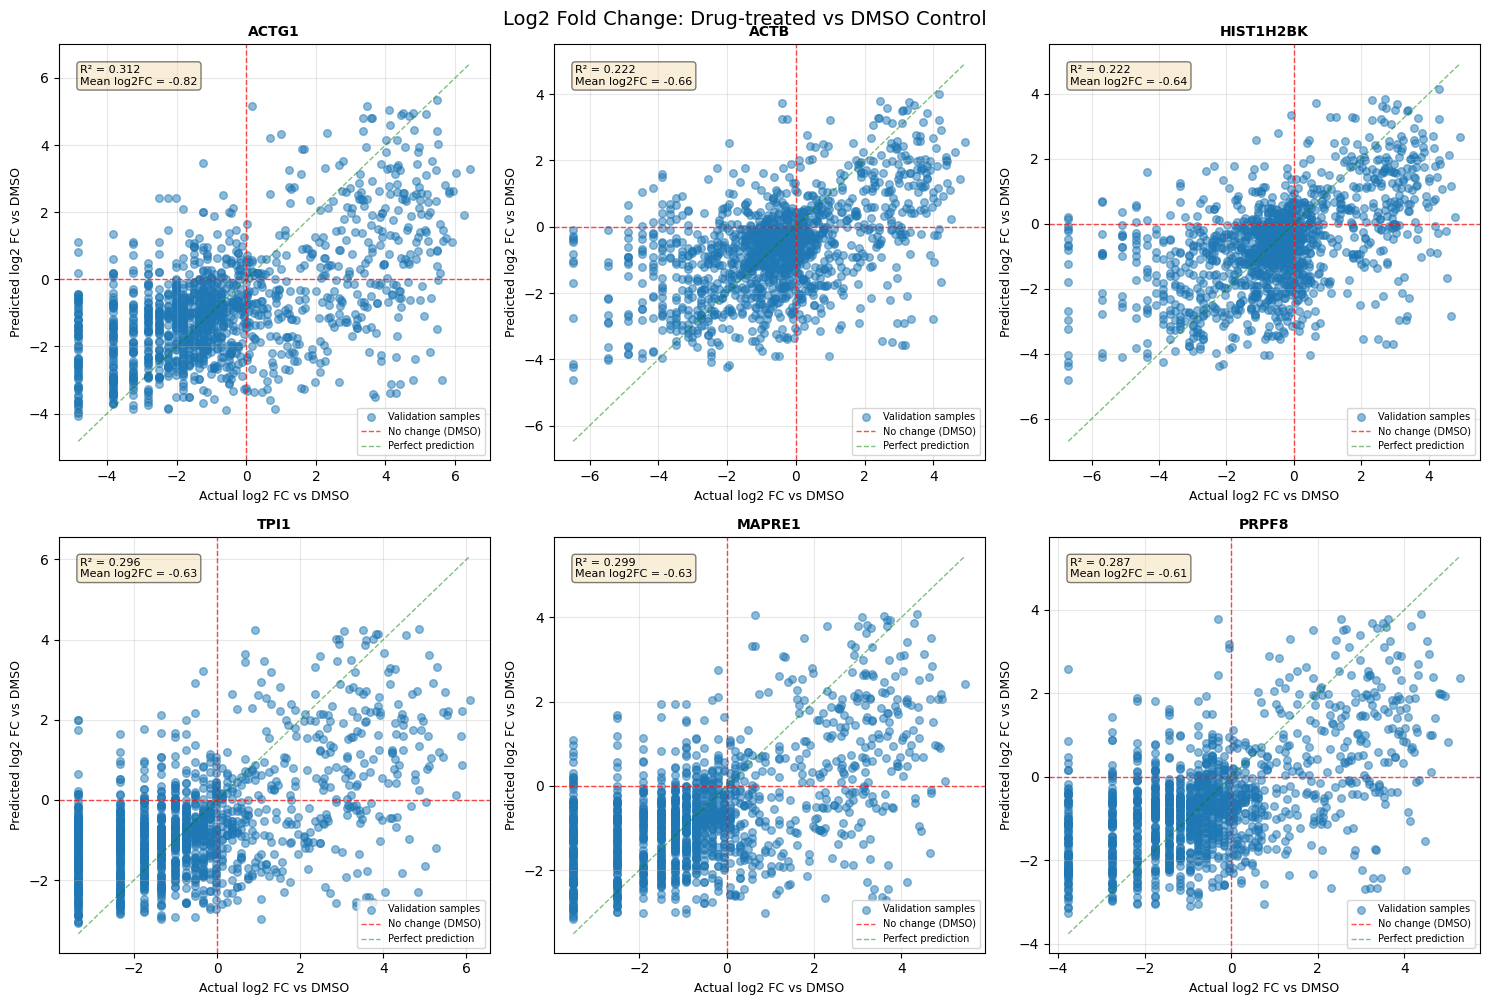

In [43]:
# Visualize Log2 Fold Changes: Predictions vs Actual
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Select 6 genes with largest fold changes
selected_genes = top_fc_indices[:6]

for idx, gene_idx in enumerate(selected_genes):
    ax = axes[idx]
    gene_name = gene_names[gene_idx]
    
    # Calculate log2 FC for each sample
    sample_log2fc_actual = (targets[:, gene_idx] - dmso_mean_profile[gene_idx]) / np.log(2)
    sample_log2fc_pred = (predictions[:, gene_idx] - dmso_mean_profile[gene_idx]) / np.log(2)
    
    # Create scatter plot of log2 fold changes
    ax.scatter(sample_log2fc_actual, sample_log2fc_pred, alpha=0.5, s=30, label='Validation samples')
    
    # Add zero line (no change from DMSO)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7, label='No change (DMSO)')
    ax.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.7)
    
    # Perfect prediction line
    min_val = min(sample_log2fc_actual.min(), sample_log2fc_pred.min())
    max_val = max(sample_log2fc_actual.max(), sample_log2fc_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'g--', linewidth=1, alpha=0.5, label='Perfect prediction')
    
    # R² score and mean log2FC
    r2 = r2_score(sample_log2fc_actual, sample_log2fc_pred)
    mean_fc = log2_fc_predictions[gene_idx]
    ax.text(0.05, 0.95, f'R² = {r2:.3f}\nMean log2FC = {mean_fc:.2f}', 
            transform=ax.transAxes, verticalalignment='top', fontsize=8, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_xlabel('Actual log2 FC vs DMSO', fontsize=9)
    ax.set_ylabel('Predicted log2 FC vs DMSO', fontsize=9)
    ax.set_title(f'{gene_name}', fontsize=10, fontweight='bold')
    ax.legend(fontsize=7, loc='lower right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Log2 Fold Change: Drug-treated vs DMSO Control', fontsize=14, y=1.00)
plt.show()

In [ ]:
from umap import UMAP

import matplotlib.pyplot as plt

# Reduce dimensionality using UMAP
umap = UMAP(n_components=2, random_state=42)
umap_embedding = umap.fit_transform(counts_df.values)

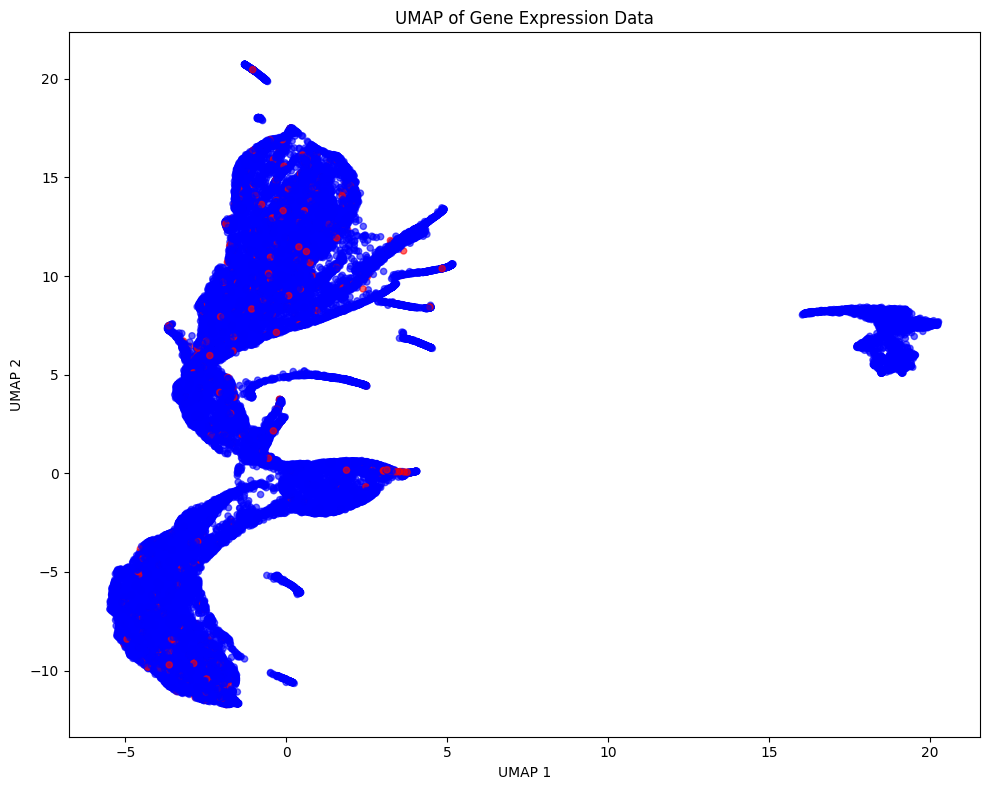

In [43]:
# Create visualization
plt.figure(figsize=(10, 8))
# Get DMSO sample indices
dmso_indices = metadata_df[metadata_df['treatment'] == 'DMSO'].index
dmso_mask = np.isin(np.arange(len(counts_df)), dmso_indices)

# Create color array
colors = np.where(dmso_mask, 'red', 'blue')

plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=colors, alpha=0.6, s=20)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP of Gene Expression Data')
plt.tight_layout()
plt.show()